# The Variability Hypothesis

In [342]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [343]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(17)

<IPython.core.display.Javascript object>

In [345]:
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

<IPython.core.display.Javascript object>

In [346]:
def write_hdf():
    """Read the SAS export file and write an HDF file."""
    brfss = pd.read_sas("LLCP2022.XPT.gz")
    columns = ["__SEX", "HTM4", "WTKG3", "_LLCPWT"]
    brfss[columns].to_hdf("LLCP2022.hdf5", key="brfss", complevel=6)

<IPython.core.display.Javascript object>

In [347]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/LLCP2022.hdf5")

<IPython.core.display.Javascript object>

In [348]:
brfss = pd.read_hdf("LLCP2022.hdf5", key="brfss")
brfss.describe()

,_SEX,HTM4,WTKG3,_LLCPWT
count,445132.000000,416480.000000,403054.000000,445132.000000
mean,1.529942,170.269057,8307.447039,594.856344
std,0.499103,10.717750,2144.817270,1134.837415
min,1.000000,91.000000,2268.000000,0.020464
25%,1.000000,163.000000,6804.000000,115.885991
50%,2.000000,170.000000,8074.000000,274.632388
75%,2.000000,178.000000,9525.000000,627.913694
max,2.000000,241.000000,29257.000000,54390.520926


<IPython.core.display.Javascript object>

In [349]:
def resample(df):
    n = len(df)
    return df.sample(n, replace=True, weights="_LLCPWT")

<IPython.core.display.Javascript object>

In [350]:
sample = resample(brfss)

<IPython.core.display.Javascript object>

## Difference in means

In [63]:
def diff(seq):
    return np.diff(seq)[0]

<IPython.core.display.Javascript object>

In [64]:
def diff_means(sample):
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    return diff(grouped_heights.mean())

<IPython.core.display.Javascript object>

In [65]:
diff_means(sample)

-14.430919670440886

<IPython.core.display.Javascript object>

In [66]:
def sampling_dist(df, test_stat, iters=101):
    return [test_stat(resample(df)) for i in range(iters)]

<IPython.core.display.Javascript object>

In [67]:
t1 = sampling_dist(brfss, diff_means)
np.mean(t1)

-14.434818060633452

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Difference in means (cm)')

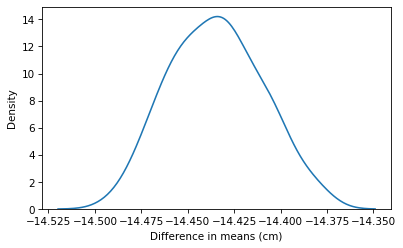

<IPython.core.display.Javascript object>

In [68]:
sns.kdeplot(t1)
plt.xlabel("Difference in means (cm)")

In [69]:
from scipy.stats import norm


def p_value(t):
    m, s = np.mean(t), np.std(t)
    if m > 0:
        return norm.cdf(0, m, s)
    else:
        return norm.sf(0, m, s)

<IPython.core.display.Javascript object>

In [70]:
p_value(t1)

0.0

<IPython.core.display.Javascript object>

In [71]:
def remove_spines():
    """Remove the spines from a plot."""
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_ticks([])

<IPython.core.display.Javascript object>

In [72]:
def add_rho(rho):
    """Adds a label to a figure to indicate the correlation."""
    ax = plt.gca()
    plt.text(
        0.5,
        0.05,
        f"ρ = {rho}",
        fontsize="large",
        transform=ax.transAxes,
        ha="center",
        va="center",
    )

<IPython.core.display.Javascript object>

In [73]:
def summarize(data):
    m, s = np.mean(data), np.std(data)
    qs = np.linspace(m - 4 * s, m + 4 * s, 201)
    ps = gaussian_kde(data)(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    low, high = pmf.make_cdf().inverse([0.03, 0.97])
    return m, low, high

<IPython.core.display.Javascript object>

In [116]:
format(0.1, "0.2f")

'0.10'

<IPython.core.display.Javascript object>

In [139]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf


def plot_sampling_distribution(data, format_str=".2f", **options):
    """ """
    # compute the mean and CI
    m, s = np.mean(data), np.std(data)
    qs = np.linspace(m - 4 * s, m + 4 * s, 501)
    ps = gaussian_kde(data)(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    low, high = pmf.make_cdf().inverse([0.025, 0.975])

    # plot the density
    pmf.plot(**options)
    inside = pmf[(pmf.qs >= low) & (pmf.qs <= high)]
    plt.fill_between(inside.index, inside, color="gray", alpha=0.2)

    y = pmf.max()
    ax = plt.gca()

    # add text and lines
    plt.text(m, 0.4 * y, "mean", fontsize=14, ha="center")
    plt.text(m, 0.05 * y, f"95% CI", fontsize=14, ha="center")
    plt.plot([m, m], [0, y], ls=":", color="gray")
    plt.plot([low, high], [0, 0], ls="-", color="gray")

    # adjust xticks
    ticks = [low, m, high]
    labels = [format(tick, format_str) for tick in ticks]
    ax.tick_params(axis="x", labelsize=14)
    plt.xticks(ticks, labels)
    plt.yticks([])

    # remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

<IPython.core.display.Javascript object>

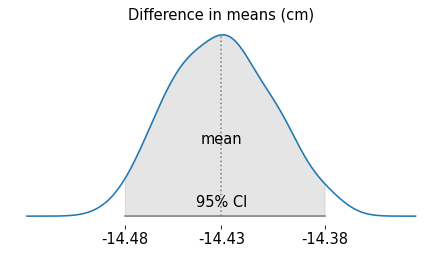

<IPython.core.display.Javascript object>

In [146]:
plot_sampling_distribution(t1)
plt.title("Difference in means (cm)", fontsize=14)
plt.tight_layout()
plt.savefig("variability1.png", dpi=300)

## Difference in standard deviations

In [20]:
def diff_stds(sample):
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    return diff(grouped_heights.std())

<IPython.core.display.Javascript object>

In [21]:
diff_stds(sample)

-0.8099293428477594

<IPython.core.display.Javascript object>

In [22]:
t2 = sampling_dist(brfss, diff_stds)
np.mean(t2)

-0.8087979018259059

<IPython.core.display.Javascript object>

1.480230032613795e-206

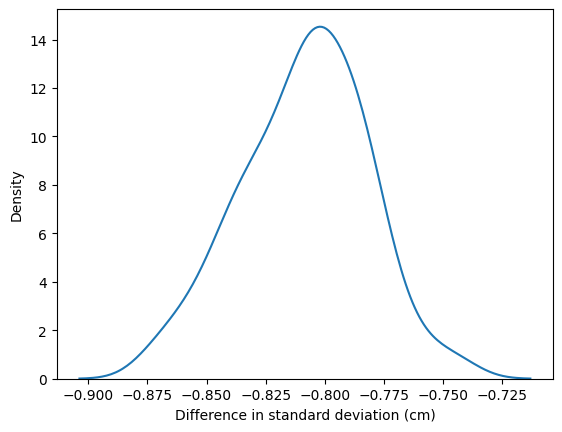

<IPython.core.display.Javascript object>

In [23]:
sns.kdeplot(t2)
plt.xlabel("Difference in standard deviation (cm)")
p_value(t2)

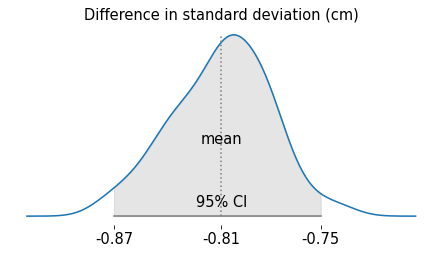

<IPython.core.display.Javascript object>

In [147]:
plot_sampling_distribution(t2)
plt.title("Difference in standard deviation (cm)", fontsize=14)
plt.tight_layout()
plt.savefig("variability2.png", dpi=300)

## Difference in coefficient of variation

In [24]:
def diff_cvs(sample):
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    means = grouped_heights.mean()
    stds = grouped_heights.std()
    return diff(stds / means)

<IPython.core.display.Javascript object>

In [25]:
t3 = sampling_dist(brfss, diff_cvs)
np.mean(t3)

-0.0006885705151001938

<IPython.core.display.Javascript object>

0.0001712105157787081

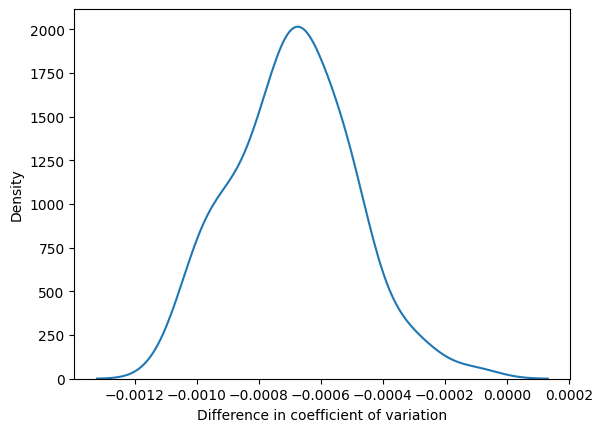

<IPython.core.display.Javascript object>

In [26]:
sns.kdeplot(t3)
plt.xlabel("Difference in coefficient of variation")
p_value(t3)

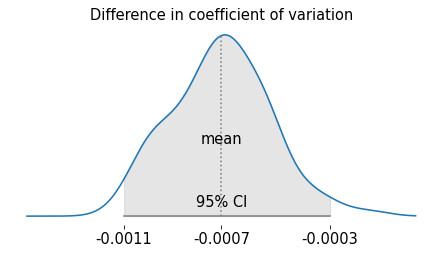

<IPython.core.display.Javascript object>

In [149]:
plot_sampling_distribution(t3, format_str="0.4f")
plt.title("Difference in coefficient of variation", fontsize=14)
plt.tight_layout()
plt.savefig("variability3.png", dpi=300)

## Difference in IQR / median

In [27]:
def diff_relative_iqr(sample):
    sample["HTM4"] += np.random.normal(0, 1, size=len(sample))
    grouped_heights = sample.groupby("_SEX")["HTM4"]
    medians = grouped_heights.median()
    iqrs = grouped_heights.quantile(0.75) - grouped_heights.quantile(0.25)
    return diff(iqrs / medians)

<IPython.core.display.Javascript object>

In [28]:
diff_relative_iqr(sample)

0.004675844479229738

<IPython.core.display.Javascript object>

In [29]:
t4 = sampling_dist(brfss, diff_relative_iqr)
np.mean(t4)

0.004648172337693843

<IPython.core.display.Javascript object>

2.7363124072325e-80

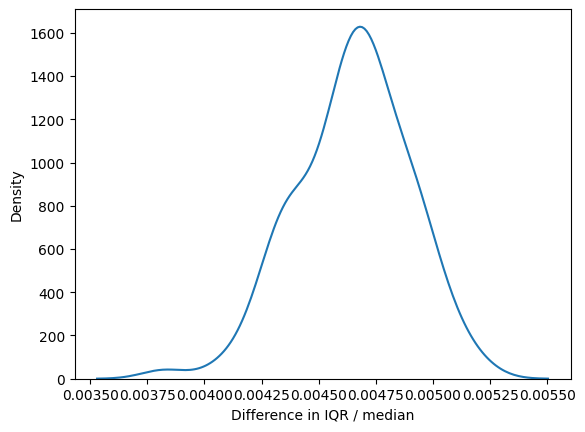

<IPython.core.display.Javascript object>

In [32]:
sns.kdeplot(t4)
plt.xlabel("Difference in IQR / median")
p_value(t4)

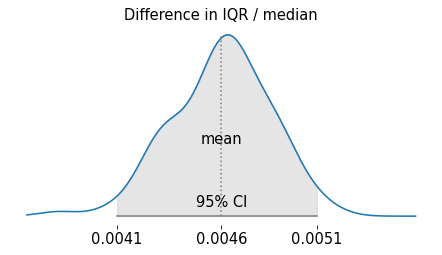

<IPython.core.display.Javascript object>

In [150]:
plot_sampling_distribution(t4, format_str="0.4f")
plt.title("Difference in IQR / median", fontsize=14)
plt.tight_layout()
plt.savefig("variability4.png", dpi=300)

## Animate

In [799]:
nrows, ncols = 7, 12
nrows, ncols = 6, 11


xs = np.arange(ncols)
ys = nrows - np.arange(nrows) - 1
X1, Y1 = np.meshgrid(xs, ys, indexing="xy")

<IPython.core.display.Javascript object>

In [800]:
X0 = np.full_like(X1, 0)
Y0 = Y1

<IPython.core.display.Javascript object>

In [801]:
def make_selection(nrows, ncols, nselect):
    array = np.zeros((nrows, ncols))
    row_indices = np.random.randint(nrows, size=nselect)
    col_indices = np.random.randint(ncols, size=nselect)
    array[row_indices, col_indices] = 1
    return array

<IPython.core.display.Javascript object>

In [802]:
np.random.seed(1)

alpha0 = np.full((nrows, ncols), 0)
alpha0[:, 0] = 1
alpha1 = np.full((nrows, ncols), 1)
alpha2 = make_selection(nrows, ncols, nrows)

<IPython.core.display.Javascript object>

In [803]:
indices = np.transpose(np.nonzero(alpha2))
X2 = np.zeros_like(X0)
Y2 = np.zeros_like(Y0)

for k, (i, j) in enumerate(indices):
    X2[i, j] = xs.max()
    Y2[i, j] = ys.max() - k

<IPython.core.display.Javascript object>

In [804]:
from scipy.special import expit


def interpolate(A0, A1, t):
    if t > 0 and t < 1:
        t = expit((t - 0.5) * 10)
    return A0 * (1 - t) + A1 * t

<IPython.core.display.Javascript object>

In [845]:
markers = ["o", "s", "d", "^", "p", "P", "H", "v", "<", ">"]
colors = plt.cm.tab10.colors


def draw_array(X, Y, alphas):
    """ 
    """
    plt.clf()

    nrows, ncols = X.shape
    for i in range(nrows):
        marker, color = markers[i], colors[i]
        [
            plt.plot(X[i, j], Y[i, j], marker, color=color, ms=12, alpha=alphas[i, j])
            for j in range(ncols)
        ]

    plt.xlim(-0.5, ncols - 0.5)
    plt.ylim(-0.5, nrows - 0.5)

    remove_spines()
    plt.tight_layout()

<IPython.core.display.Javascript object>

In [846]:
def draw_phase1(t):
    X = interpolate(X0, X1, t)
    Y = interpolate(Y0, Y1, t)
    alpha = interpolate(alpha0, alpha1, t)
    draw_array(X, Y, alpha)

<IPython.core.display.Javascript object>

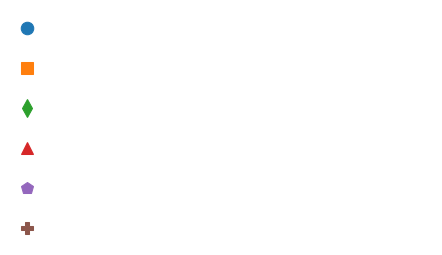

<IPython.core.display.Javascript object>

In [847]:
draw_phase1(0)
plt.savefig("resampling_phase0.png", dpi=300)

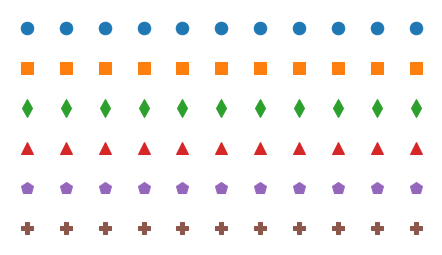

<IPython.core.display.Javascript object>

In [848]:
draw_phase1(1)

In [849]:
def draw_phase2(t):
    alpha = interpolate(alpha1, alpha2, t)
    draw_array(X1, Y1, alpha)

<IPython.core.display.Javascript object>

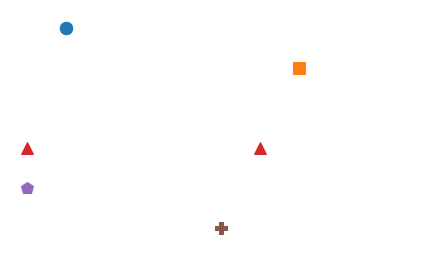

<IPython.core.display.Javascript object>

In [850]:
draw_phase2(1)

In [851]:
def draw_phase3(t):
    X = interpolate(X1, X2, t)
    Y = interpolate(Y1, Y2, t)
    alpha = alpha2
    draw_array(X, Y, alpha)

<IPython.core.display.Javascript object>

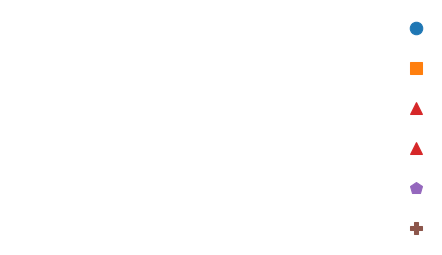

<IPython.core.display.Javascript object>

In [852]:
draw_phase3(1)

In [866]:
import imageio
from io import BytesIO


def savegif(filename, draw_frame_func):
    num_frames = 24
    frames = []

    for i in range(num_frames):
        t = i / (num_frames - 1)
        draw_frame_func(t)

        # Save the frame to a BytesIO object
        buf = BytesIO()
        plt.savefig(buf, format="png", dpi=300)
        buf.seek(0)
        frames.append(imageio.v2.imread(buf))

    # Save frames as GIF
    plt.close()
    imageio.mimsave(filename, frames, duration=1 / 24)

<IPython.core.display.Javascript object>

In [867]:
filename1 = "resampling_phase1.gif"
savegif(filename1, draw_phase1)

<IPython.core.display.Javascript object>

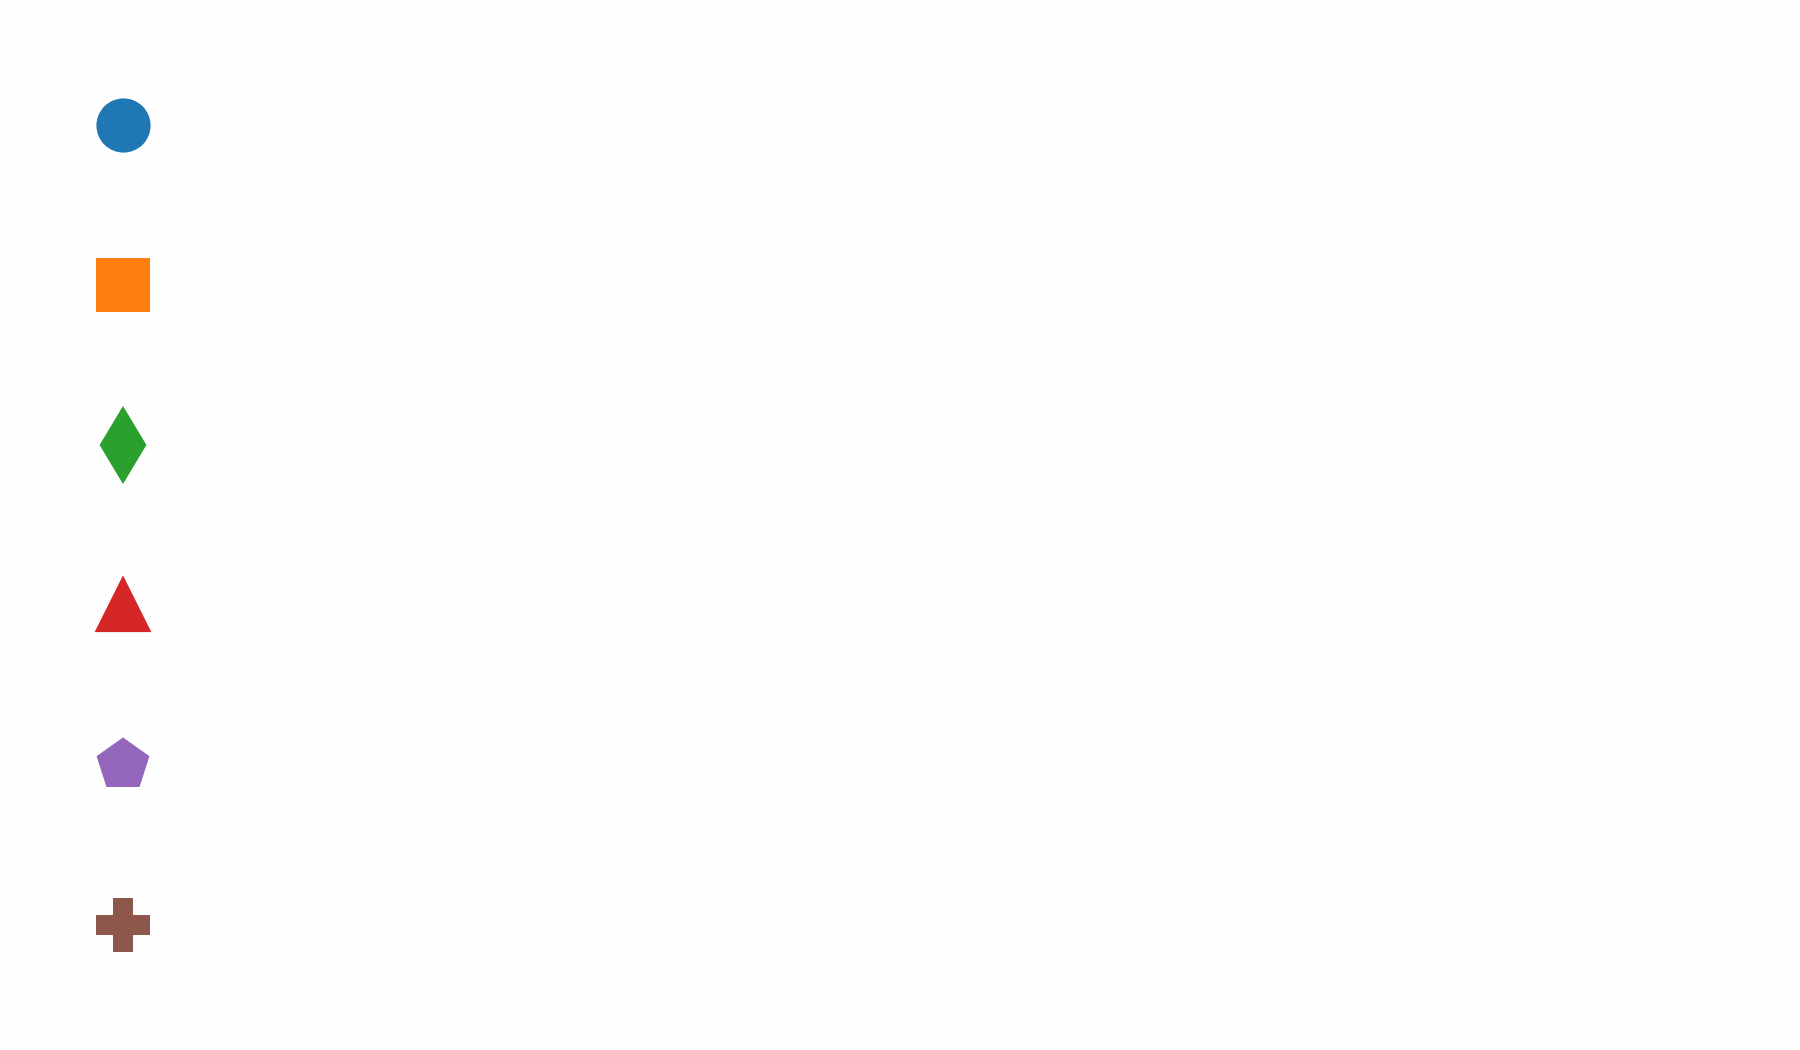

<IPython.core.display.Javascript object>

In [868]:
from IPython.display import display, Image

display(Image(filename=filename1))

In [869]:
filename2 = "resampling_phase2.gif"
savegif(filename2, draw_phase2)

<IPython.core.display.Javascript object>

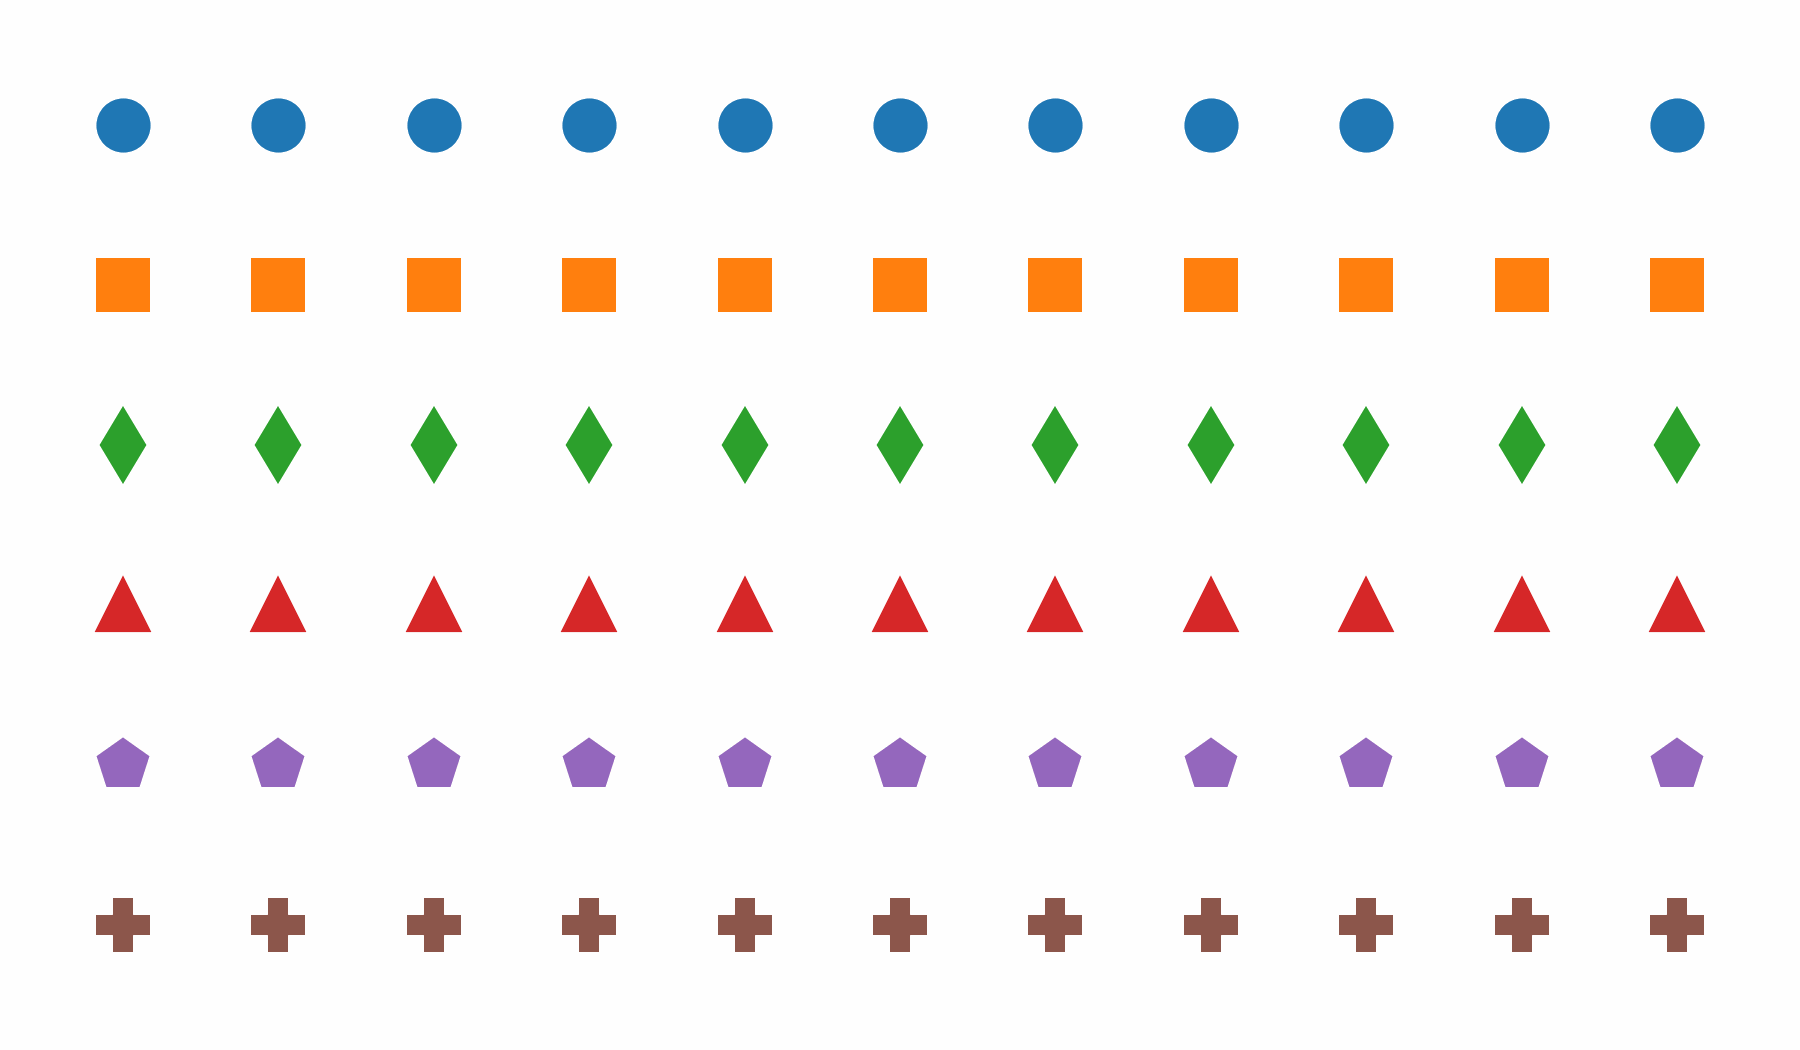

<IPython.core.display.Javascript object>

In [870]:
display(Image(filename=filename2))

In [871]:
filename3 = "resampling_phase3.gif"
savegif(filename3, draw_phase3)

<IPython.core.display.Javascript object>

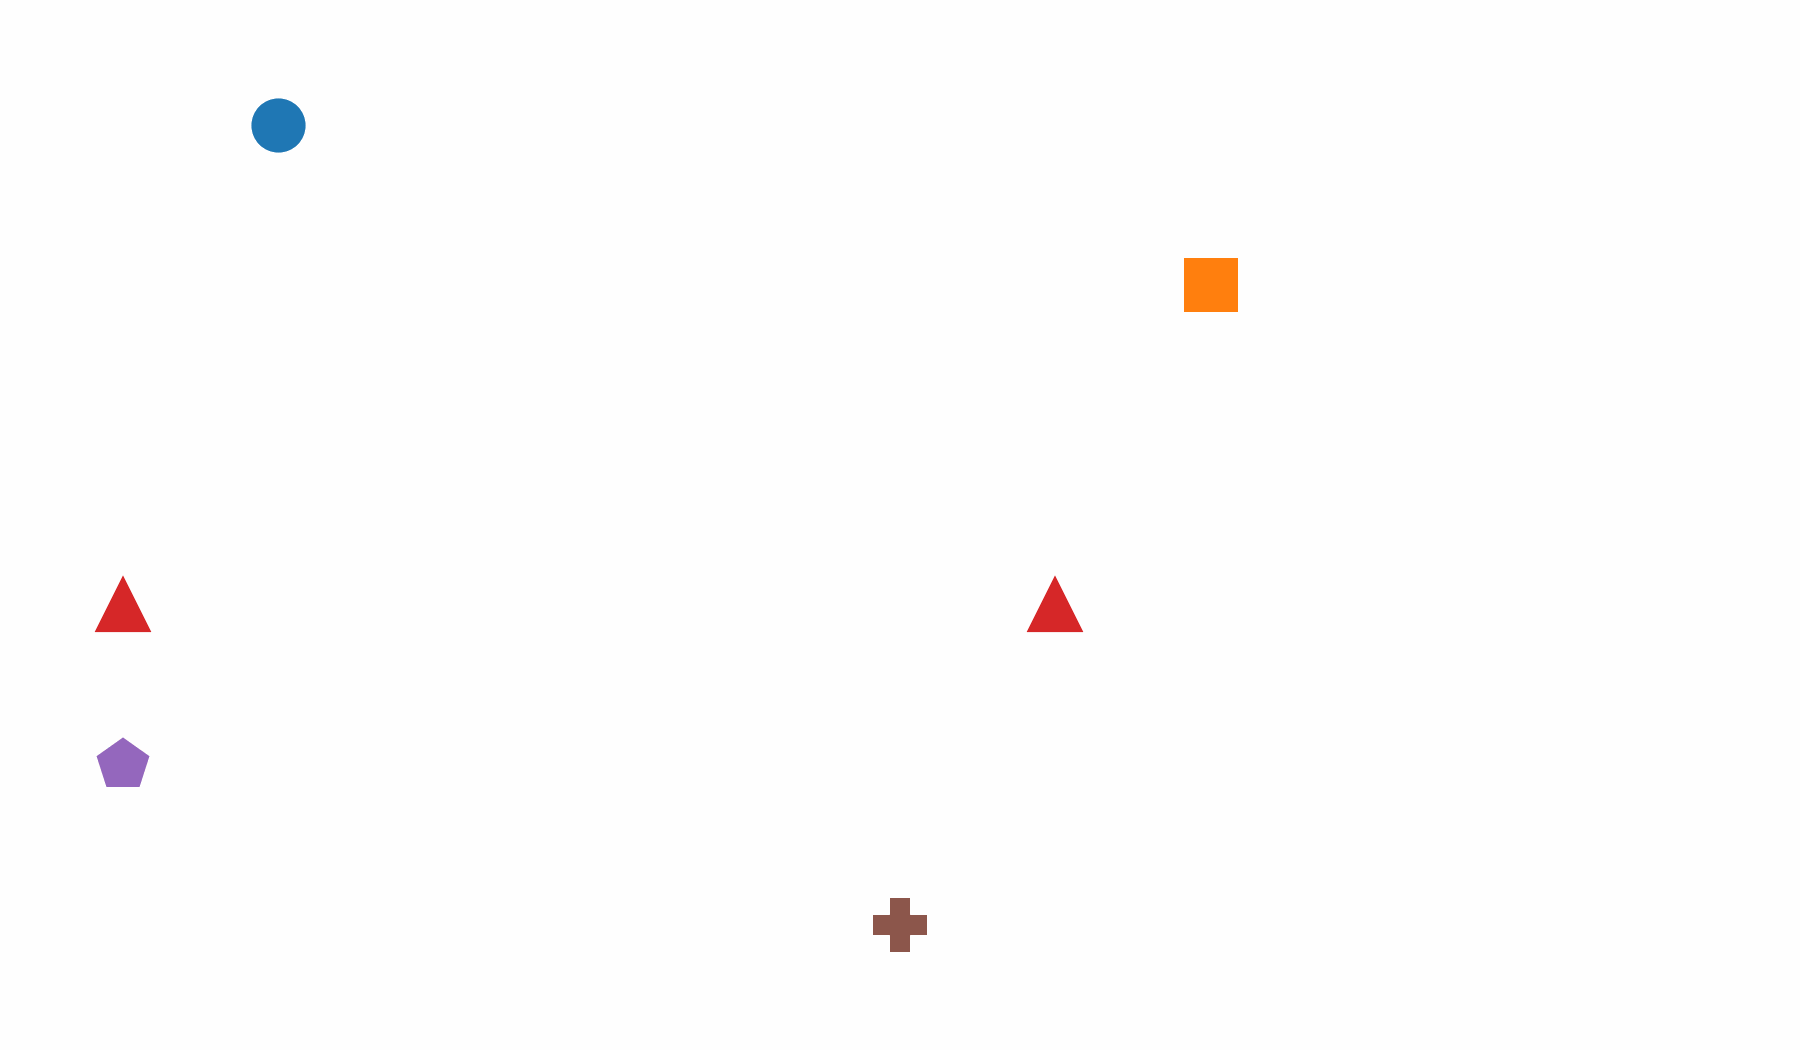

<IPython.core.display.Javascript object>

In [872]:
display(Image(filename=filename3))